# Elementwise Average Fusion model training (focal loss) cosine scheduler like the cliplike method:

In [18]:
import sys
root = '../'
sys.path.append(root)   # Done to be able to import the packages and functions

import Utils.hico_evaluation.evaluation as ev
from Utils.custom_loss import MaskedFocalLoss
from Utils.annotation_preprocessing import _load_csv_to_tensor
from Utils.train_val_split import train_val_split_hico
from hoi_classifiers import ElementwiseAvgFusionModel

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from pytorch_multilabel_balanced_sampler.samplers import LeastSampledClassSampler
import random

In [19]:
seed = 42   #note that the model parameters will still be randomly initiated
torch.manual_seed(seed)
random.seed(seed)

### Loading the training set:


In [20]:
# Loading the data:
train_data = torch.load(root + "Embeddings/Combined_Embeddings/train.pt")
train_annotations = _load_csv_to_tensor(root + "anno/added/anno_augmented_train.csv").T # Transpose to make both first dimensions the #samples.
train_annotations[train_annotations.isnan()] = -1

##### Splitting the training set into a train and validation set:

In [21]:
train_idx, validation_idx = train_val_split_hico(train_data, train_annotations, 0.2, seed)
X_train, X_val = train_data[train_idx], train_data[validation_idx]
y_train, y_val = train_annotations[train_idx], train_annotations[validation_idx]

#### Training Preparations:

In [22]:
train_dataset = TensorDataset(X_train, y_train)

In [23]:
# Batch size:
bs = 512

#sampler = LeastSampledClassSampler((y_train[:,:600] == 1).int())

train_dataloader = DataLoader(
    train_dataset, batch_size=bs, num_workers=4, shuffle=True)


In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
model = ElementwiseAvgFusionModel(512,655,797)
model = model.to(device)

In [26]:
classweights = torch.cat((torch.ones(600),torch.ones(197)*0.5)).to(device)      # The hoi classes weigh twice as much as the seperate classes
criterion = MaskedFocalLoss(ignore_label=0, convert_target_to_01= True, weight=classweights)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

#### Training loop:

In [27]:
num_epochs = 200
training_loss_per_epoch = np.zeros(200)
validation_loss_per_epoch = np.zeros(200)
validation_map_per_epoch = np.zeros(200)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
    
    scheduler.step()

    with torch.no_grad():
        pred = model.forward(X_val.to(device))
        # calculate the validation loss:
        validation_loss = criterion(pred, y_val.to(device))
        # calculate the validation mAP:
        validation_aps = ev.eval_vo(pred[:,:600].T.cpu().detach().numpy(), y_val[:,:600].T.numpy(),600)[0]
        nr_val_classes = np.sum(validation_aps != None)
        validation_map = np.nansum(validation_aps) / nr_val_classes

    # add the losses and mAP to the arrays:
    training_loss_per_epoch[epoch] = running_loss / len(train_dataloader)
    validation_loss_per_epoch[epoch] = validation_loss
    validation_map_per_epoch[epoch] = validation_map

    print(f"Epoch {epoch+1:0{len(str(num_epochs))}}/{num_epochs}, Loss: {running_loss/len(train_dataloader):.12f}, validation map: {validation_map:.12f}")

Epoch 001/200, Loss: 0.017311262813, validation map: 0.014503393589
Epoch 002/200, Loss: 0.001862108149, validation map: 0.063945502844
Epoch 003/200, Loss: 0.001468501859, validation map: 0.099761598626
Epoch 004/200, Loss: 0.001287947564, validation map: 0.118912372897
Epoch 005/200, Loss: 0.001221543065, validation map: 0.124179253980
Epoch 006/200, Loss: 0.001101483362, validation map: 0.176811131047
Epoch 007/200, Loss: 0.000943722914, validation map: 0.218373344201
Epoch 008/200, Loss: 0.000862199007, validation map: 0.241213890724
Epoch 009/200, Loss: 0.000823293128, validation map: 0.254543330036
Epoch 010/200, Loss: 0.000807046082, validation map: 0.257225031480
Epoch 011/200, Loss: 0.000784450874, validation map: 0.285118243517
Epoch 012/200, Loss: 0.000743214016, validation map: 0.307776091012
Epoch 013/200, Loss: 0.000713720982, validation map: 0.322254819579
Epoch 014/200, Loss: 0.000696413076, validation map: 0.329308864801
Epoch 015/200, Loss: 0.000687821562, validation 

### plotting the training process to select the number of convergence

[]

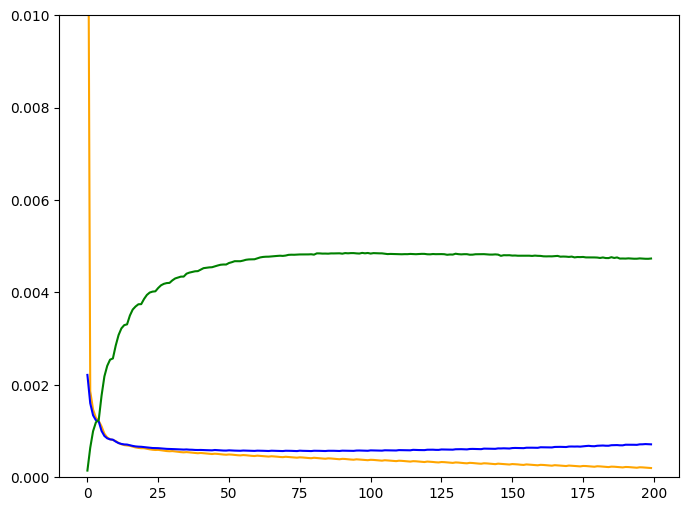

In [28]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(200), training_loss_per_epoch, color = "orange")
plt.plot(np.arange(200), validation_loss_per_epoch, color = "blue")
# plt.plot(np.arange(100), validation_loss_main_per_epoch, color= "red")
# plt.plot(np.arange(100), validation_loss_side_per_epoch, color = "purple")
plt.plot(np.arange(200), validation_map_per_epoch/100, color = "green")
#plt.hlines(0.010051161982119083, 0, 100 , colors=['black'],linestyles=['dotted'])
plt.ylim(0,0.01)
plt.plot()

In [29]:
np.argmax(validation_map_per_epoch)

97

In [30]:
np.argmin(validation_loss_per_epoch)

74